In [2]:
import chemical_analysis as ca
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import json
import os 

from torchvision.models.feature_extraction import get_graph_node_names
from chemical_analysis.alkalinity import AlkalinitySampleDataset, ProcessedAlkalinitySampleDataset
from torchvision.models import vgg11
from torchsummary import summary
from torchvision.models.feature_extraction import create_feature_extractor

### Preprocessing

#### analyte object

In [53]:
samples = AlkalinitySampleDataset(
    base_dirs = 'Alkalinity_Samples',  
    progress_bar = True, 
    skip_blank_samples = False, 
    skip_incomplete_samples = True, 
    skip_inference_sample= True, 
    skip_training_sample = False, 
    verbose = True
)

In [55]:
processed_sample = ProcessedAlkalinitySampleDataset(
    dataset = samples, 
    cache_dir = 'cache_dir',
    num_augmented_samples = 0, 
    progress_bar = True, 
    transform = None,
)

In [57]:
len(processed_sample)

767

In [61]:
processed_sample.alkalinity_values[210]['sourceStock']['value']

8027.0

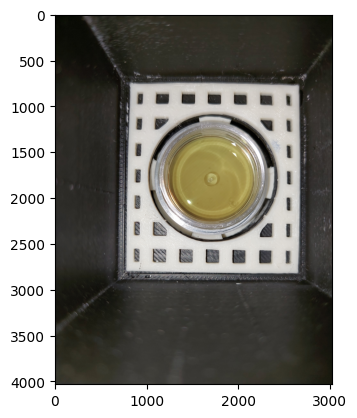

In [62]:
plt.imshow(cv2.cvtColor(processed_sample[-5].sample_bgr_image, cv2.COLOR_BGR2RGB))   #converte a imagem para RGB 

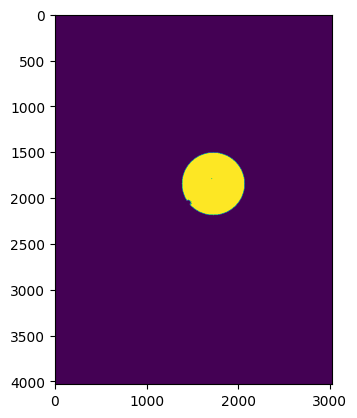

In [63]:
plt.imshow(processed_sample[-5].sample_analyte_mask)

#### centered cropping

##### Example of cropping for one image

In [64]:
heigth = len(processed_sample[0].sample_bgr_image)
width = len(processed_sample[0].sample_bgr_image[0])

#heigth crop
heigth_crop = processed_sample[0].sample_bgr_image[int(heigth/2)-112:int(heigth/2)+112]

#width crop
final_image = np.zeros((224,224,3)) #expected input for vgg11
for line in range(0,225):
    try:
        final_image[line] = heigth_crop[line][int(width/2)-112:int(width/2)+112]
    except: pass



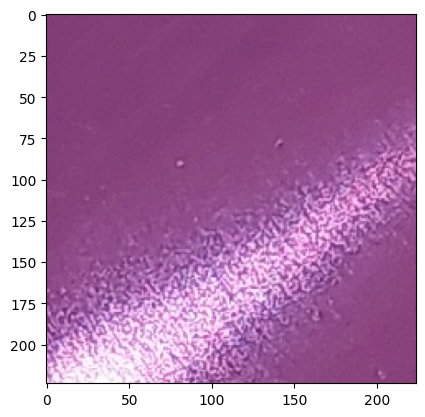

In [65]:
plt.imshow(cv2.cvtColor(final_image.astype('uint8'), cv2.COLOR_BGR2RGB))

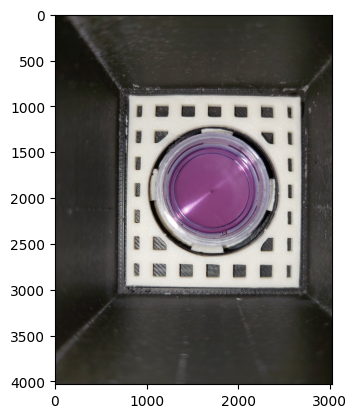

In [66]:
plt.imshow(cv2.cvtColor(processed_sample[0].sample_bgr_image, cv2.COLOR_BGR2RGB))

In [67]:
len(processed_sample)

767

##### cropp all images

In [69]:
cropped_images = []

for i, _ in enumerate(processed_sample):
    heigth = len(processed_sample[i].sample_bgr_image)
    width = len(processed_sample[i].sample_bgr_image[0])
    actual_image = processed_sample[i]

#heigth crop
    heigth_crop = actual_image.sample_bgr_image[int(heigth/2)-112:int(heigth/2)+112]

#width crop
    final_image = np.zeros((224,224,3)) #expected input for vgg11
    for line in range(0,224):
        final_image[line] = heigth_crop[line][int(width/2)-112:int(width/2)+112]
    cropped_images.append(final_image)

In [70]:
len(cropped_images)

767

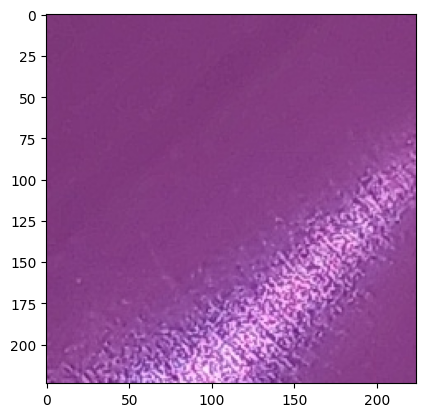

In [71]:
plt.imshow(cv2.cvtColor(cropped_images[20].astype('uint8'),cv2.COLOR_BGR2RGB))

##### Save cropped images and alkalinity value

In [75]:
for i, image in enumerate(cropped_images):
    plt.imsave(f"./images/{i}.png", image/255)
    with open(f"./images/{i}", "w", encoding='utf-8') as f:
        json.dump(processed_sample.alkalinity_values[i]['sourceStock']['value'],f, ensure_ascii=False, indent=4)

### Feature Extraction

In [89]:
# load images
cropped_images = []

for image in sorted(os.listdir("./images/")):
    if image.endswith(".png"):
        cropped_images.append(cv2.imread(f"./images/{image}"))

In [94]:
sorted(os.listdir("./images/"))

['sample_0',
 'sample_0.png',
 'sample_1',
 'sample_1.png',
 'sample_10',
 'sample_10.png',
 'sample_100',
 'sample_100.png',
 'sample_101',
 'sample_101.png',
 'sample_102',
 'sample_102.png',
 'sample_103',
 'sample_103.png',
 'sample_104',
 'sample_104.png',
 'sample_105',
 'sample_105.png',
 'sample_106',
 'sample_106.png',
 'sample_107',
 'sample_107.png',
 'sample_108',
 'sample_108.png',
 'sample_109',
 'sample_109.png',
 'sample_11',
 'sample_11.png',
 'sample_110',
 'sample_110.png',
 'sample_111',
 'sample_111.png',
 'sample_112',
 'sample_112.png',
 'sample_113',
 'sample_113.png',
 'sample_114',
 'sample_114.png',
 'sample_115',
 'sample_115.png',
 'sample_116',
 'sample_116.png',
 'sample_117',
 'sample_117.png',
 'sample_118',
 'sample_118.png',
 'sample_119',
 'sample_119.png',
 'sample_12',
 'sample_12.png',
 'sample_120',
 'sample_120.png',
 'sample_121',
 'sample_121.png',
 'sample_122',
 'sample_122.png',
 'sample_123',
 'sample_123.png',
 'sample_124',
 'sample_124.

In [4]:
vgg11 = vgg11()

In [5]:
summary(vgg11, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [49]:
#cria o symbolic trace do torch.FX
train_nodes, eval_nodes = get_graph_node_names(vgg11)
train_nodes

['x',
 'features.0',
 'features.1',
 'features.2',
 'features.3',
 'features.4',
 'features.5',
 'features.6',
 'features.7',
 'features.8',
 'features.9',
 'features.10',
 'features.11',
 'features.12',
 'features.13',
 'features.14',
 'features.15',
 'features.16',
 'features.17',
 'features.18',
 'features.19',
 'features.20',
 'avgpool',
 'flatten',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6']

In [50]:
feature_list = ['features.2', 'features.5', 'features.7',  ]#'features.10']

In [51]:
#cria o extrator de caracteristicas
feature_extraction = create_feature_extractor(
                                              model = vgg11,
                                              return_nodes= feature_list
                                              )

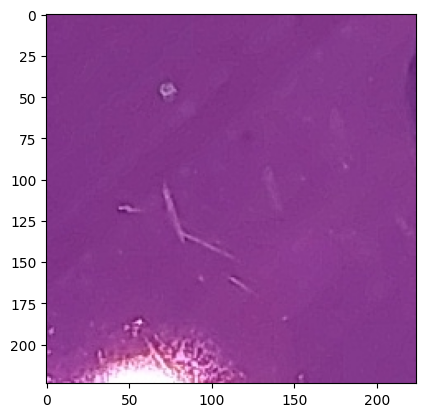

In [93]:
plt.imshow(cv2.cvtColor(cropped_images[4], cv2.COLOR_BGR2RGB))

In [85]:
# extract the features
img_choice = cropped_images[-1].astype('uint8') # escolhe uma imagem

img_choice = torch.from_numpy(img_choice).permute(2, 0, 1).unsqueeze(0).float()  #converte a imagem para o formato de tensor

with torch.no_grad():
    output = feature_extraction(img_choice)

for i, _ in enumerate(feature_list):
    print(output[feature_list[i]].shape)

torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 56, 56])


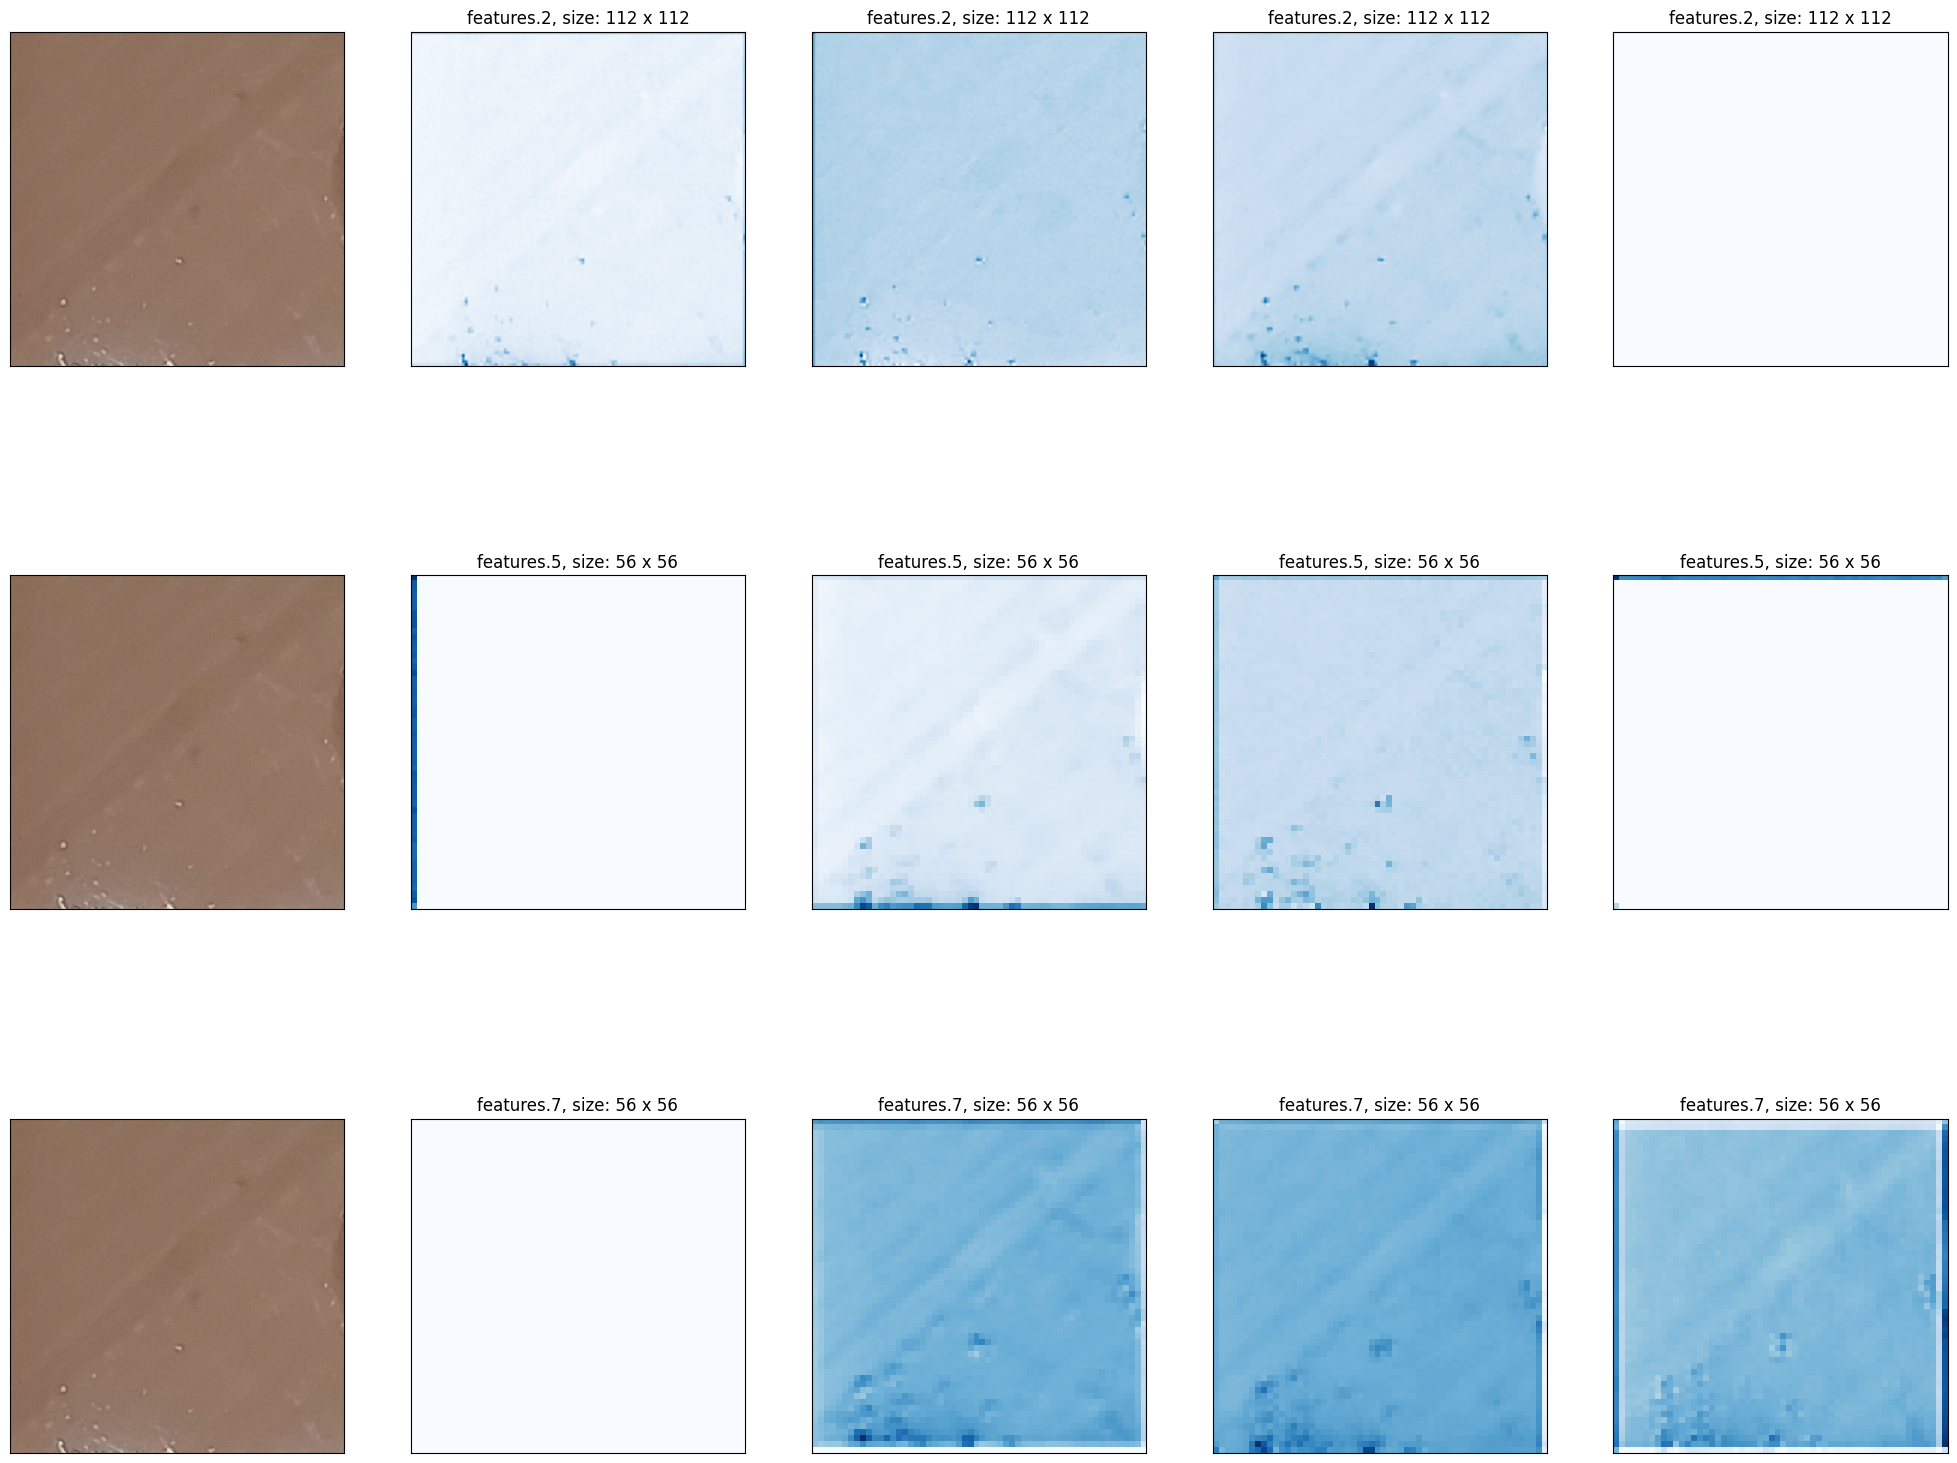

In [86]:
fig, ax = plt.subplots(len(feature_list), 5, figsize=(25, 20))

for i, layer in enumerate(feature_list):
    feat_maps = output[layer].numpy().squeeze(0)
    feat_maps = random.sample(list(feat_maps), 4)
    #ax[i][0].imshow(img_choice)
    ax[i][0].imshow(img_choice.numpy().squeeze().transpose(1, 2, 0).astype('uint8'))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j, feat_map in enumerate(feat_maps):
        ax[i][j+1].imshow(feat_map, cmap='Blues')  
        ax[i][j+1].set_xticks([])
        ax[i][j+1].set_yticks([])
        ax[i][j+1].set_title(f'{layer}, size: {feat_map.shape[0]} x {feat_map.shape[1]}')

plt.show()


### teste

In [ ]:
class Vgg11(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.body = feature_extraction

In [ ]:
model = Vgg11().eval()

#### teste 1 com torch.fx

In [ ]:
#https://www.youtube.com/watch?v=QRQBTkCLpFY&ab_channel=Alex-AI   min 10:30

In [12]:
from torch.fx import symbolic_trace

In [13]:
sybolic_traced = symbolic_trace(vgg11)
print(sybolic_traced.code)




def forward(self, x : torch.Tensor) -> torch.Tensor:
    features_0 = getattr(self.features, "0")(x);  x = None
    features_1 = getattr(self.features, "1")(features_0);  features_0 = None
    features_2 = getattr(self.features, "2")(features_1);  features_1 = None
    features_3 = getattr(self.features, "3")(features_2);  features_2 = None
    features_4 = getattr(self.features, "4")(features_3);  features_3 = None
    features_5 = getattr(self.features, "5")(features_4);  features_4 = None
    features_6 = getattr(self.features, "6")(features_5);  features_5 = None
    features_7 = getattr(self.features, "7")(features_6);  features_6 = None
    features_8 = getattr(self.features, "8")(features_7);  features_7 = None
    features_9 = getattr(self.features, "9")(features_8);  features_8 = None
    features_10 = getattr(self.features, "10")(features_9);  features_9 = None
    features_11 = getattr(self.features, "11")(features_10);  features_10 = None
    features_12 = getattr(self.f

#### teste 2 com torchvision feature extraction

In [14]:
from torchvision.models.feature_extraction import get_graph_node_names

In [15]:
train_nodes, eval_nodes = get_graph_node_names(vgg11)

In [16]:
train_nodes

['x',
 'features.0',
 'features.1',
 'features.2',
 'features.3',
 'features.4',
 'features.5',
 'features.6',
 'features.7',
 'features.8',
 'features.9',
 'features.10',
 'features.11',
 'features.12',
 'features.13',
 'features.14',
 'features.15',
 'features.16',
 'features.17',
 'features.18',
 'features.19',
 'features.20',
 'avgpool',
 'flatten',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6']